# Load data

## Start Spark Session

In [1]:
# Change the number of cores in this code block
# by setting `spark.master` to `local[n]` where
# n is the number of cores
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

import matplotlib.pyplot as plt

conf = pyspark.SparkConf().setAll([('spark.master', 'local[2]'),
                                   ('spark.app.name', 'Basic Setup')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2022-05-30 22:55:01,811 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# params
load_cleaned = False

## Load Data

Read data from the `ratings.csv` file

In [3]:
if load_cleaned:
    r_path    = 'file:///home/work/data/cleaned_ratings'
    dist_path = '../../data/cleaned_rating_dist.png'
    prop_path = '../../data/cleaned_rating_prop.png'
else:
    r_path    = 'file:///home/work/data/ratings.csv'
    dist_path = '../../data/rating_count.png'
    prop_path = '../../data/rating_prop.png'

In [4]:
ratings_df = spark.read.option("header",True).csv(r_path).cache()
ratings_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- movieId: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- timestamp: string (nullable = true)



In [5]:
ratings_df.show()

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    296|   5.0|1147880044|
|     1|    306|   3.5|1147868817|
|     1|    307|   5.0|1147868828|
|     1|    665|   5.0|1147878820|
|     1|    899|   3.5|1147868510|
|     1|   1088|   4.0|1147868495|
|     1|   1175|   3.5|1147868826|
|     1|   1217|   3.5|1147878326|
|     1|   1237|   5.0|1147868839|
|     1|   1250|   4.0|1147868414|
|     1|   1260|   3.5|1147877857|
|     1|   1653|   4.0|1147868097|
|     1|   2011|   2.5|1147868079|
|     1|   2012|   2.5|1147868068|
|     1|   2068|   2.5|1147869044|
|     1|   2161|   3.5|1147868609|
|     1|   2351|   4.5|1147877957|
|     1|   2573|   4.0|1147878923|
|     1|   2632|   5.0|1147878248|
|     1|   2692|   5.0|1147869100|
+------+-------+------+----------+
only showing top 20 rows



## Look at the data

In [6]:
ratings_df.describe().toPandas()

2022-05-30 22:55:48,222 WARN memory.MemoryStore: Not enough space to cache rdd_13_3 in memory! (computed 83.9 MiB so far)
2022-05-30 22:55:48,226 WARN storage.BlockManager: Persisting block rdd_13_3 to disk instead.
2022-05-30 22:55:50,094 WARN memory.MemoryStore: Not enough space to cache rdd_13_3 in memory! (computed 54.6 MiB so far)
2022-05-30 22:55:52,790 WARN memory.MemoryStore: Not enough space to cache rdd_13_4 in memory! (computed 54.6 MiB so far)
2022-05-30 22:55:52,790 WARN storage.BlockManager: Persisting block rdd_13_4 to disk instead.


,summary,userId,movieId,rating,timestamp
0,count,25000095,25000095,25000095,25000095
1,mean,81189.28115381162,21387.981943268616,3.533854451353085,1.2156014431215513E9
2,stddev,46791.71589745776,39198.86210105973,1.0607439611423535,2.268758080595386E8
3,min,1,1,0.5,1000000065
4,max,99999,99999,5.0,999999978


In [7]:
ratings_df.groupBy('userID').count().sort(col("count").desc()).show()

2022-05-30 22:56:05,218 WARN memory.MemoryStore: Not enough space to cache rdd_13_3 in memory! (computed 22.6 MiB so far)
2022-05-30 22:56:05,865 WARN memory.MemoryStore: Not enough space to cache rdd_13_4 in memory! (computed 83.6 MiB so far)


+------+-----+
|userID|count|
+------+-----+
| 72315|32202|
| 80974| 9178|
|137293| 8913|
| 33844| 7919|
| 20055| 7488|
|109731| 6647|
| 92046| 6564|
| 49403| 6553|
| 30879| 5693|
|115102| 5649|
|110971| 5633|
| 75309| 5525|
| 78849| 5276|
| 61010| 5244|
| 29803| 5219|
|122011| 5160|
| 57548| 5066|
| 93855| 5045|
|103611| 4861|
| 34987| 4831|
+------+-----+
only showing top 20 rows



In [8]:
ratings_df.groupBy('userID').count().describe().show()

2022-05-30 22:56:07,604 WARN memory.MemoryStore: Not enough space to cache rdd_13_3 in memory! (computed 83.9 MiB so far)
2022-05-30 22:56:08,036 WARN memory.MemoryStore: Not enough space to cache rdd_13_4 in memory! (computed 22.7 MiB so far)


+-------+------------------+------------------+
|summary|            userID|             count|
+-------+------------------+------------------+
|  count|            162541|            162541|
|   mean|           81271.0|153.80793153727367|
| stddev|46921.689389521205|    268.0475900845|
|    min|                 1|                20|
|    max|             99999|             32202|
+-------+------------------+------------------+



In [9]:
# Find median ratings for users
median = ratings_df.groupBy('userID').count().sort(col("count").desc()).approxQuantile("count", [0.5], 0.25)
print(f"Median ratings by user: {median}")

2022-05-30 22:56:10,000 WARN memory.MemoryStore: Not enough space to cache rdd_13_3 in memory! (computed 83.9 MiB so far)
2022-05-30 22:56:10,456 WARN memory.MemoryStore: Not enough space to cache rdd_13_4 in memory! (computed 22.7 MiB so far)


Median ratings by user: [39.0]


In [10]:
r = ratings_df.groupBy('rating').count().sort(col("rating").asc())
r = r.toPandas()
r["prop"] = (r["count"] / r["count"].sum()) * 100

2022-05-30 22:56:12,950 WARN memory.MemoryStore: Not enough space to cache rdd_13_3 in memory! (computed 83.9 MiB so far)
2022-05-30 22:56:13,377 WARN memory.MemoryStore: Not enough space to cache rdd_13_4 in memory! (computed 35.4 MiB so far)


## Plot the data

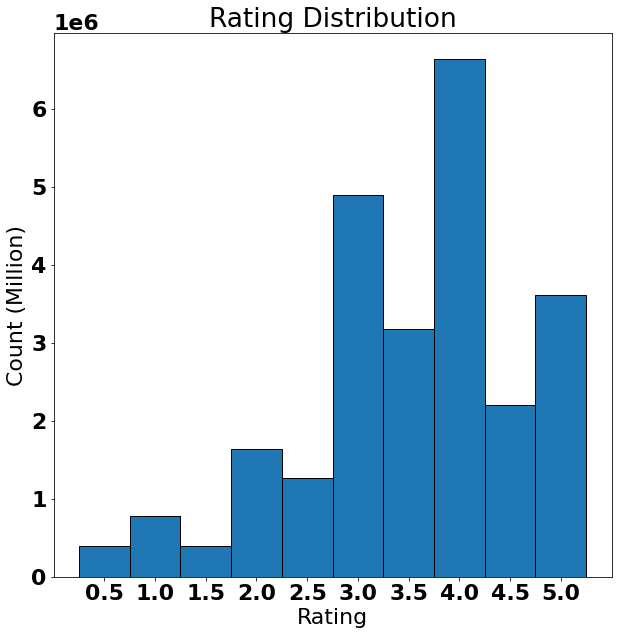

In [11]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

plt.figure(figsize=(10,10))
plt.bar(r["rating"], r["count"],width=1,edgecolor='k')
plt.title("Rating Distribution")
plt.ylabel("Count (Million)")
plt.xlabel("Rating")
ax = plt.gca()
plt.savefig(dist_path)

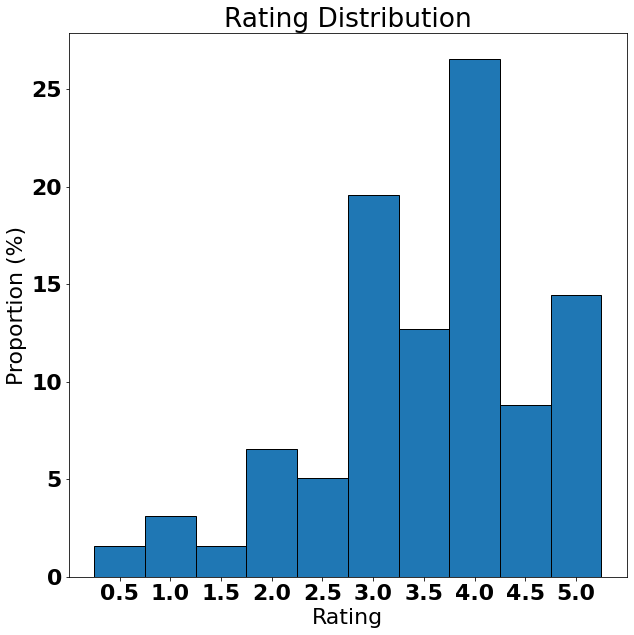

In [12]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

plt.figure(figsize=(10,10))
plt.bar(r["rating"], r["prop"],width=1,edgecolor='k')
plt.title("Rating Distribution")
plt.ylabel("Proportion (%)")
plt.xlabel("Rating")
ax = plt.gca()
plt.savefig(prop_path)

In [13]:
spark.stop()